In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


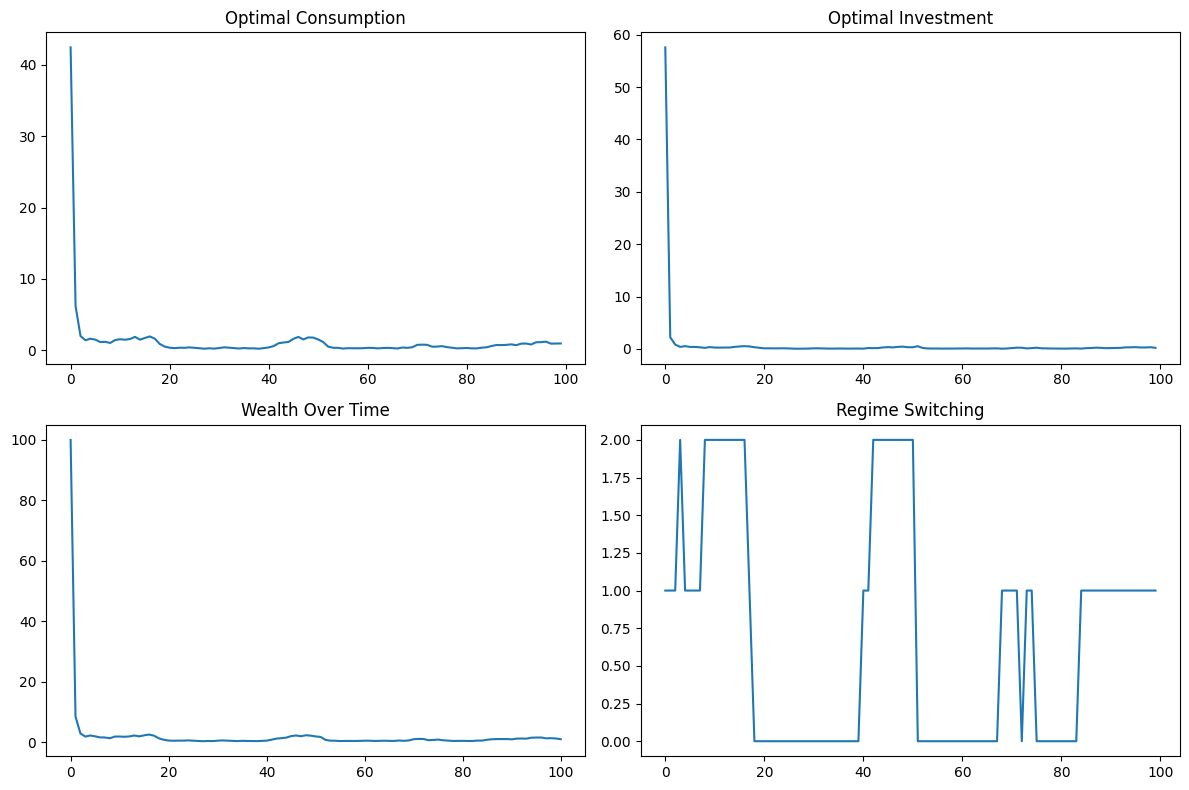

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
beta = 0.95  # Discount factor
gamma = 2.0  # Risk aversion parameter
alpha = 0.36  # Cobb-Douglas parameter for production
states = [0, 1, 2]  # Economic regimes: e.g., 0 = recession, 1 = normal, 2 = expansion
transition_matrix = np.array([[0.9, 0.08, 0.02],
                              [0.1, 0.8, 0.1],
                              [0.05, 0.1, 0.85]])  # Markov transition matrix
num_periods = 100
initial_state = 1  # Start in normal regime
initial_wealth = 100

# Utility function (Power utility)
def utility(c, gamma):
    if c > 0:
        return (c ** (1 - gamma)) / (1 - gamma)
    else:
        return -np.inf  # Infeasible if consumption is zero or negative

# Cobb-Douglas production function
def production(investment, regime, alpha):
    # Shock term for randomness
    shock = np.random.uniform(0.8, 1.2)  # Add some randomness to productivity
    return (investment ** alpha) * shock * (regime + 1)

# Function to simulate the Markov regime switching
def simulate_markov_chain(num_periods, initial_state, transition_matrix):
    states = len(transition_matrix)
    regime = initial_state
    history = [regime]
    for _ in range(num_periods - 1):
        next_regime = np.random.choice(states, p=transition_matrix[regime])
        history.append(next_regime)
        regime = next_regime
    return history

# Function to solve the consumption-investment optimization
def optimal_policy(wealth, regime, beta, gamma, alpha, periods):
    consumption_history = []
    investment_history = []
    wealth_history = [wealth]
    regime_history = simulate_markov_chain(periods, initial_state, transition_matrix)

    for t in range(periods):
        regime = regime_history[t]
        current_wealth = wealth_history[-1]

        # Try different consumption values to maximize utility
        best_consumption = 0
        best_utility = -np.inf
        for consumption in np.linspace(0, current_wealth, 100):
            investment = current_wealth - consumption
            next_wealth = production(investment, regime, alpha)
            future_utility = beta * utility(next_wealth, gamma)
            current_utility = utility(consumption, gamma) + future_utility
            if current_utility > best_utility:
                best_utility = current_utility
                best_consumption = consumption

        # Record optimal consumption and investment
        optimal_investment = current_wealth - best_consumption
        next_wealth = production(optimal_investment, regime, alpha)

        consumption_history.append(best_consumption)
        investment_history.append(optimal_investment)
        wealth_history.append(next_wealth)

    return consumption_history, investment_history, wealth_history, regime_history

# Run simulation
consumption, investment, wealth, regimes = optimal_policy(initial_wealth, initial_state, beta, gamma, alpha, num_periods)

# Plot the results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(consumption)
plt.title('Optimal Consumption')

plt.subplot(2, 2, 2)
plt.plot(investment)
plt.title('Optimal Investment')

plt.subplot(2, 2, 3)
plt.plot(wealth)
plt.title('Wealth Over Time')

plt.subplot(2, 2, 4)
plt.plot(regimes)
plt.title('Regime Switching')

plt.tight_layout()
plt.show()


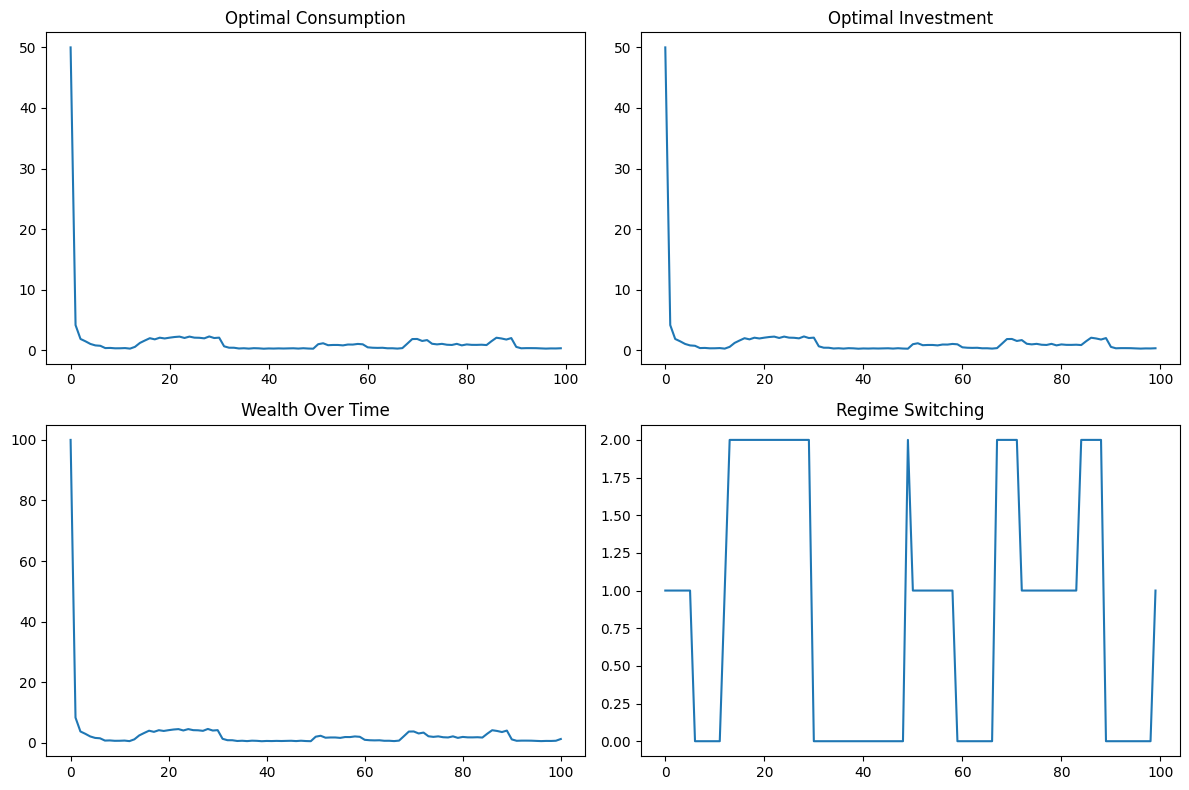

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Parameters
beta = 0.95  # Discount factor
gamma = 2.0  # Risk aversion parameter
alpha = 0.36  # Cobb-Douglas parameter for production
initial_wealth = 100
num_periods = 100
states = [0, 1, 2]  # Regimes: 0 = recession, 1 = normal, 2 = expansion

# Function for calculating transition probabilities based on external factors
def transition_probs(inflation, interest_rate):
    if inflation < 5 and interest_rate < 6:
        return np.array([[0.9, 0.08, 0.02], [0.1, 0.8, 0.1], [0.05, 0.1, 0.85]])  # Stable growth
    elif inflation > 7:
        return np.array([[0.7, 0.2, 0.1], [0.3, 0.6, 0.1], [0.2, 0.1, 0.7]])  # High inflation risks
    else:
        return np.array([[0.85, 0.1, 0.05], [0.15, 0.7, 0.15], [0.1, 0.15, 0.75]])  # Normal conditions

# Cobb-Douglas production function with random shock
def production(investment, regime, alpha):
    shock = np.random.uniform(0.8, 1.2)  # Random shock
    return (investment ** alpha) * shock * (regime + 1)

# Utility function (Power utility)
def utility(c, gamma):
    if c > 0:
        return (c ** (1 - gamma)) / (1 - gamma)
    else:
        return -np.inf

# Function to simulate the Markov chain with varying transition probabilities
def simulate_markov_chain(num_periods, initial_state, inflation, interest_rate):
    transition_matrix = transition_probs(inflation, interest_rate)
    regimes = [initial_state]
    for _ in range(num_periods - 1):
        next_regime = np.random.choice(states, p=transition_matrix[regimes[-1]])
        regimes.append(next_regime)
    return regimes

# Function to optimize consumption and investment
def optimize_policy(wealth, inflation, interest_rate, num_periods):
    regime_history = simulate_markov_chain(num_periods, initial_state=1, inflation=inflation, interest_rate=interest_rate)
    consumption_history, investment_history, wealth_history = [], [], [wealth]

    for t in range(num_periods):
        regime = regime_history[t]
        current_wealth = wealth_history[-1]

        # Define the objective function to minimize negative utility
        def objective(consumption):
            investment = current_wealth - consumption
            next_wealth = production(investment, regime, alpha)
            return -(utility(consumption, gamma) + beta * utility(next_wealth, gamma))

        # Optimize consumption using a numerical solver
        result = minimize(objective, x0=current_wealth/2, bounds=[(0, current_wealth)])
        best_consumption = result.x[0]

        # Record optimal consumption and investment
        optimal_investment = current_wealth - best_consumption
        next_wealth = production(optimal_investment, regime, alpha)

        consumption_history.append(best_consumption)
        investment_history.append(optimal_investment)
        wealth_history.append(next_wealth)

    return consumption_history, investment_history, wealth_history, regime_history

# Example run with varying inflation and interest rates
inflation = 6  # Moderate inflation
interest_rate = 5  # Interest rate
consumption, investment, wealth, regimes = optimize_policy(initial_wealth, inflation, interest_rate, num_periods)

# Plot the results
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(consumption)
plt.title('Optimal Consumption')

plt.subplot(2, 2, 2)
plt.plot(investment)
plt.title('Optimal Investment')

plt.subplot(2, 2, 3)
plt.plot(wealth)
plt.title('Wealth Over Time')

plt.subplot(2, 2, 4)
plt.plot(regimes)
plt.title('Regime Switching')

plt.tight_layout()
plt.show()


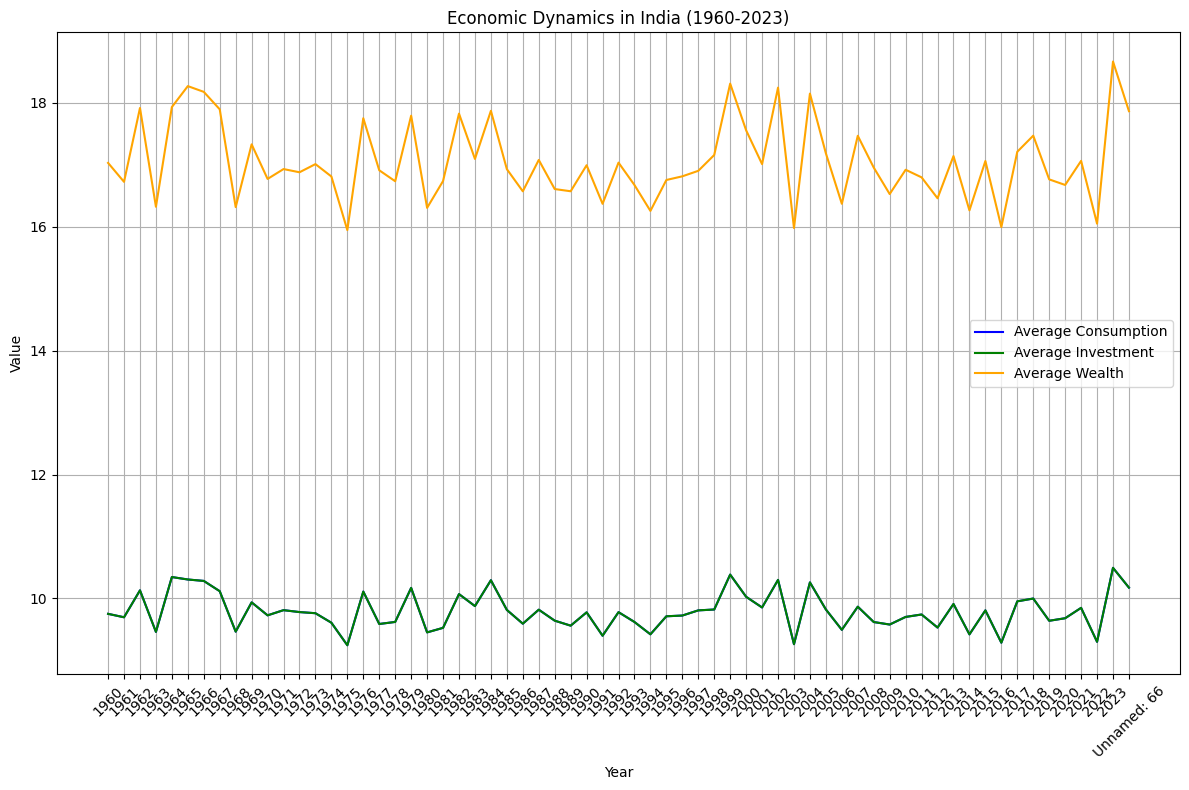

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Load the Data
data = pd.read_csv('india_econ_data.csv')

# Step 2: Preprocess the Data
# Drop non-numeric rows, keep only indicator rows
data = data[data['Indicator Name'].notnull()]

# Set the 'Indicator Name' as the index and drop unnecessary columns
data.set_index('Indicator Name', inplace=True)
data.drop(columns=['Indicator Code'], inplace=True)

# Transpose the DataFrame to have years as rows and indicators as columns
data = data.transpose()

# Convert the DataFrame to numeric, forcing errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Fill missing values using forward fill and backward fill for robustness
data.ffill(inplace=True)
data.bfill(inplace=True)

# Step 3: Select Relevant Indicators
# Defining the relevant indicators
indicators = {
    'Lending interest rate (%)': 'FR.INR.LEND',
    'Gross fixed capital formation (% of GDP)': 'NE.GDI.FTOT.ZS',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'SL.UEM.TOTL.ZS',
    'GDP growth (annual %)': 'NY.GDP.MKTP.KD.ZG',
    'Inflation, consumer prices (annual %)': 'FP.CPI.TOTL.ZG',
    'Current account balance (% of GDP)': 'BN.CAB.XOKA.GD.ZS'
}

# Extracting the relevant data for each indicator
indicator_data = {key: data[key] for key in indicators.keys()}

# Creating a DataFrame from the relevant indicators
indicators_df = pd.DataFrame(indicator_data)

# Step 4: Model Parameters
beta = 0.95  # Discount factor
gamma = 2.0  # Risk aversion parameter
alpha = 0.36  # Cobb-Douglas parameter for production
initial_wealth = 100

# Step 5: Model Implementation

# Function to calculate transition probabilities based on economic indicators
def transition_probs(inflation, interest_rate):
    if inflation < 5 and interest_rate < 6:
        return np.array([[0.9, 0.08, 0.02],
                         [0.1, 0.8, 0.1],
                         [0.05, 0.1, 0.85]])  # Stable growth
    elif inflation > 7:
        return np.array([[0.7, 0.2, 0.1],
                         [0.3, 0.6, 0.1],
                         [0.2, 0.1, 0.7]])  # High inflation risks
    else:
        return np.array([[0.85, 0.1, 0.05],
                         [0.15, 0.7, 0.15],
                         [0.1, 0.15, 0.75]])  # Normal conditions

# Cobb-Douglas production function with random shock
def production(investment, regime, alpha):
    shock = np.random.uniform(0.8, 1.2)  # Random shock
    return (investment ** alpha) * shock * (regime + 1)

# Utility function (Power utility)
def utility(c, gamma):
    if c > 0:
        return (c ** (1 - gamma)) / (1 - gamma)
    else:
        return -np.inf

# Function to simulate the Markov chain with varying transition probabilities
def simulate_markov_chain(num_periods, initial_state, inflation, interest_rate):
    transition_matrix = transition_probs(inflation, interest_rate)
    regimes = [initial_state]
    for _ in range(num_periods - 1):
        next_regime = np.random.choice([0, 1, 2], p=transition_matrix[regimes[-1]])
        regimes.append(next_regime)
    return regimes

# Function to optimize consumption and investment
def optimize_policy(wealth, inflation, interest_rate, num_periods):
    regime_history = simulate_markov_chain(num_periods, initial_state=1, inflation=inflation, interest_rate=interest_rate)
    consumption_history, investment_history, wealth_history = [], [], [wealth]

    for t in range(num_periods):
        regime = regime_history[t]
        current_wealth = wealth_history[-1]

        # Define the objective function to minimize negative utility
        def objective(consumption):
            investment = current_wealth - consumption
            next_wealth = production(investment, regime, alpha)
            return -(utility(consumption, gamma) + beta * utility(next_wealth, gamma))

        # Optimize consumption using a numerical solver
        result = minimize(objective, x0=current_wealth / 2, bounds=[(0, current_wealth)])
        best_consumption = result.x[0]

        # Record optimal consumption and investment
        optimal_investment = current_wealth - best_consumption
        next_wealth = production(optimal_investment, regime, alpha)

        consumption_history.append(best_consumption)
        investment_history.append(optimal_investment)
        wealth_history.append(next_wealth)

    return consumption_history, investment_history, wealth_history, regime_history

# Step 6: Run Simulation for Each Year
consumption_results = []
investment_results = []
wealth_results = []

# Iterate over the years in the dataset
for year in indicators_df.index:
    inflation = indicators_df.loc[year, 'Inflation, consumer prices (annual %)']
    interest_rate = indicators_df.loc[year, 'Lending interest rate (%)']
    consumption, investment, wealth, regimes = optimize_policy(initial_wealth, inflation, interest_rate, len(indicators_df.columns))

    consumption_results.append(consumption)
    investment_results.append(investment)
    wealth_results.append(wealth)

# Convert results to DataFrame for analysis
# Ensure that all results have the same length
results_df = pd.DataFrame({
    'Year': indicators_df.index,
    'Average Consumption': [np.mean(cons) for cons in consumption_results],
    'Average Investment': [np.mean(inv) for inv in investment_results],
    'Average Wealth': [np.mean(wealth) for wealth in wealth_results],
})

# Step 7: Plot Results
plt.figure(figsize=(12, 8))
plt.plot(results_df['Year'], results_df['Average Consumption'], label='Average Consumption', color='blue')
plt.plot(results_df['Year'], results_df['Average Investment'], label='Average Investment', color='green')
plt.plot(results_df['Year'], results_df['Average Wealth'], label='Average Wealth', color='orange')
plt.title('Economic Dynamics in India (1960-2023)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


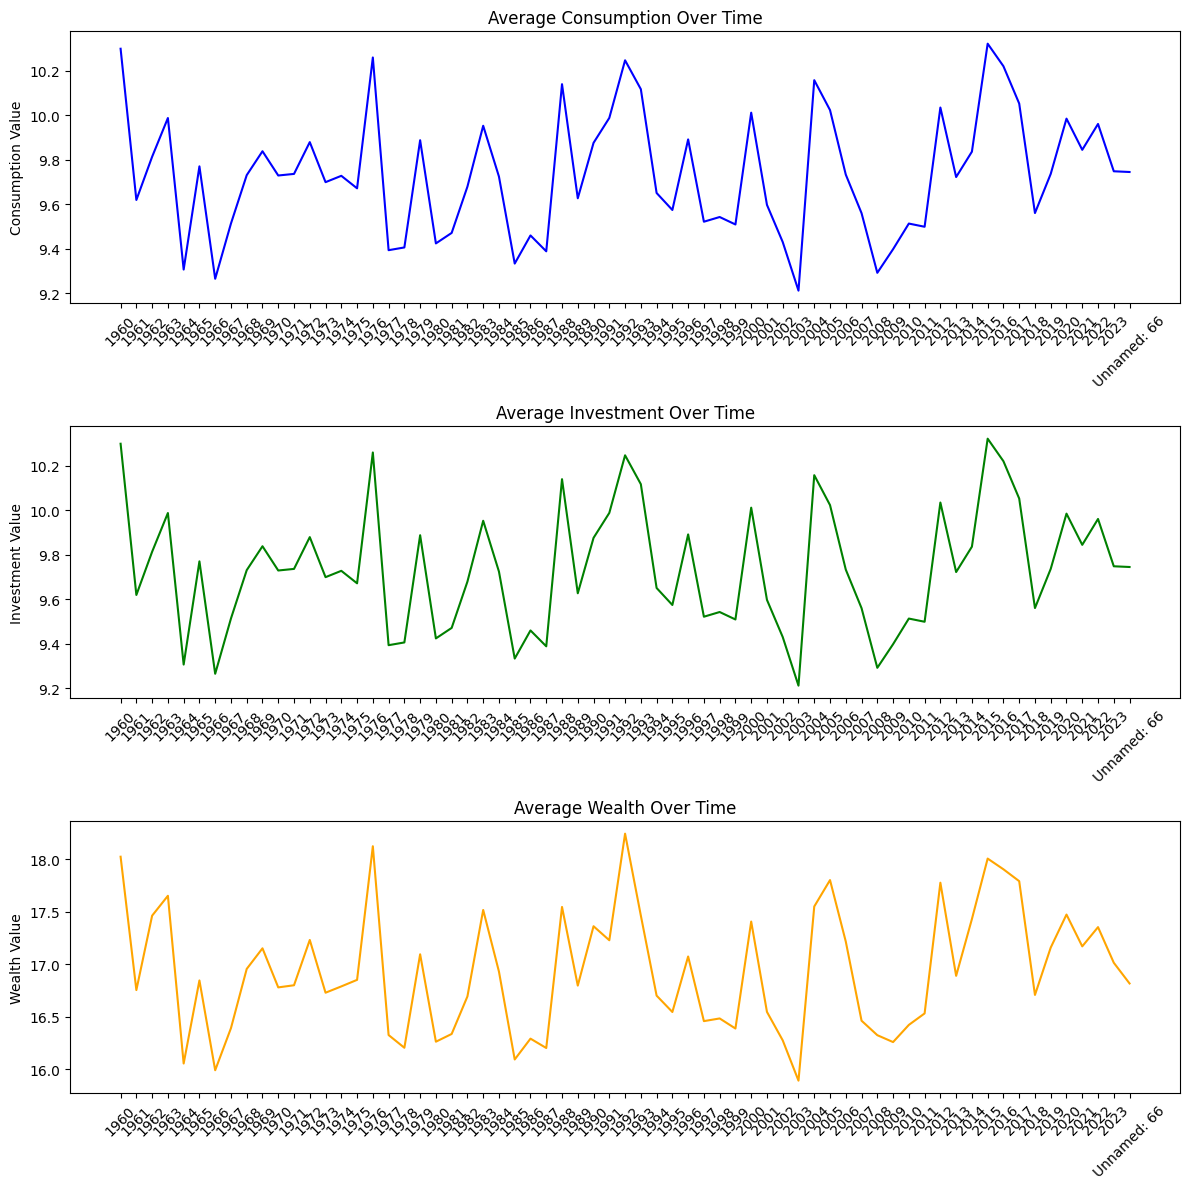

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(results_df['Year'], results_df['Average Consumption'], label='Average Consumption', color='blue')
plt.title('Average Consumption Over Time')
plt.ylabel('Consumption Value')
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
plt.plot(results_df['Year'], results_df['Average Investment'], label='Average Investment', color='green')
plt.title('Average Investment Over Time')
plt.ylabel('Investment Value')
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
plt.plot(results_df['Year'], results_df['Average Wealth'], label='Average Wealth', color='orange')
plt.title('Average Wealth Over Time')
plt.ylabel('Wealth Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Confusion Matrix:
[[ 1  0  0]
 [ 0  0  1]
 [ 0  0 11]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.92      1.00      0.96        11

    accuracy                           0.92        13
   macro avg       0.64      0.67      0.65        13
weighted avg       0.85      0.92      0.89        13



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


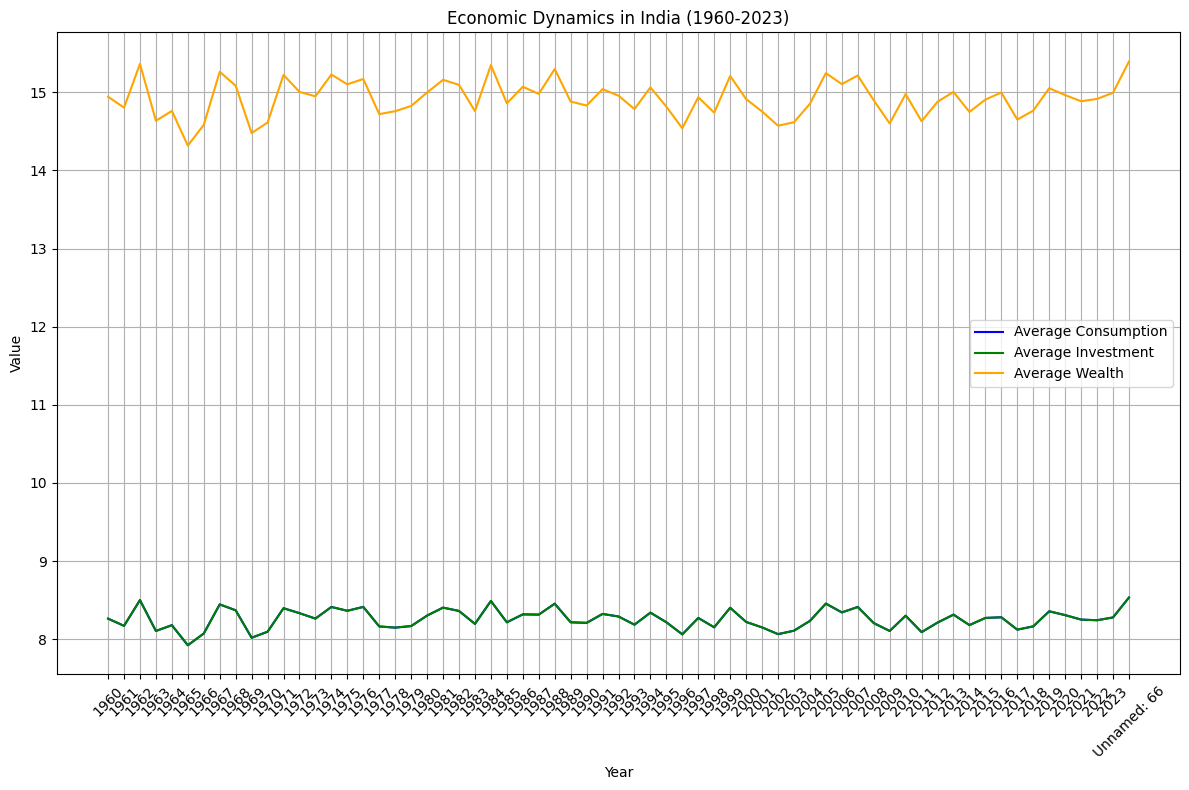

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load the Data
data = pd.read_csv('india_econ_data.csv')

# Step 2: Preprocess the Data
# Drop non-numeric rows, keep only indicator rows
data = data[data['Indicator Name'].notnull()]

# Set the 'Indicator Name' as the index and drop unnecessary columns
data.set_index('Indicator Name', inplace=True)
data.drop(columns=['Indicator Code'], inplace=True)

# Transpose the DataFrame to have years as rows and indicators as columns
data = data.transpose()

# Convert the DataFrame to numeric, forcing errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Fill missing values using forward fill and backward fill for robustness
data.ffill(inplace=True)
data.bfill(inplace=True)

# Step 3: Select Relevant Indicators
# Defining the relevant indicators
indicators = {
    'Lending interest rate (%)': 'FR.INR.LEND',
    'Gross fixed capital formation (% of GDP)': 'NE.GDI.FTOT.ZS',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'SL.UEM.TOTL.ZS',
    'GDP growth (annual %)': 'NY.GDP.MKTP.KD.ZG',
    'Inflation, consumer prices (annual %)': 'FP.CPI.TOTL.ZG',
    'Current account balance (% of GDP)': 'BN.CAB.XOKA.GD.ZS'
}

# Extracting the relevant data for each indicator
indicator_data = {key: data[key] for key in indicators.keys()}

# Creating a DataFrame from the relevant indicators
indicators_df = pd.DataFrame(indicator_data)

# Step 4: Generate Regimes using Machine Learning
# First, define a regime based on historical domain knowledge
# For example, classify based on GDP growth (manually defining regimes for training)
def create_regime_labels(df):
    labels = []
    for gdp in df['GDP growth (annual %)']:
        if gdp > 2:
            labels.append('Growth')
        elif gdp > 0:
            labels.append('Stagnation')
        else:
            labels.append('Recession')
    return labels

# Creating labels
regime_labels = create_regime_labels(indicators_df)
indicators_df['Regime'] = regime_labels

# Step 5: Prepare Features and Labels for Training
X = indicators_df.drop(columns=['Regime'])
y = indicators_df['Regime']

# Encode the labels to numerical format
y = y.map({'Recession': 0, 'Stagnation': 1, 'Growth': 2})

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Step 9: Predict Regimes on the Test Set
y_pred = rf_model.predict(X_test_scaled)

# Step 10: Evaluate Model Performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 11: Add Regime Predictions to the DataFrame
indicators_df['Predicted_Regime'] = rf_model.predict(scaler.transform(X))

# Step 12: Model Parameters for Simulation
beta = 0.95  # Discount factor
gamma = 2.0  # Risk aversion parameter
alpha = 0.36  # Cobb-Douglas parameter for production
initial_wealth = 100

# Step 13: Model Implementation
def transition_probs(regime):
    # Define transition probabilities based on regime
    if regime == 2:  # Growth
        return np.array([[0.9, 0.07, 0.03],
                         [0.1, 0.75, 0.15],
                         [0.05, 0.1, 0.85]])  # Transition probabilities when in growth
    elif regime == 1:  # Stagnation
        return np.array([[0.85, 0.1, 0.05],
                         [0.2, 0.7, 0.1],
                         [0.1, 0.15, 0.75]])  # Transition probabilities when in stagnation
    else:  # Recession
        return np.array([[0.7, 0.2, 0.1],
                         [0.3, 0.6, 0.1],
                         [0.2, 0.1, 0.7]])  # Transition probabilities when in recession

def production(investment, regime, alpha):
    shock = np.random.uniform(0.8, 1.2)  # Random shock
    return (investment ** alpha) * shock * (regime + 1)

def utility(c, gamma):
    if c > 0:
        return (c ** (1 - gamma)) / (1 - gamma)
    else:
        return -np.inf

def simulate_markov_chain(num_periods, initial_state, regimes):
    regime_history = []
    current_state = initial_state
    regime_history.append(current_state)

    for _ in range(num_periods - 1):
        transition_matrix = transition_probs(current_state)
        next_regime = np.random.choice([0, 1, 2], p=transition_matrix[current_state])
        regime_history.append(next_regime)
        current_state = next_regime

    return regime_history

def optimize_policy(wealth, regimes, num_periods):
    consumption_history, investment_history, wealth_history = [], [], [wealth]

    for t in range(num_periods):
        regime = regimes[t]
        current_wealth = wealth_history[-1]

        def objective(consumption):
            investment = current_wealth - consumption
            next_wealth = production(investment, regime, alpha)
            return -(utility(consumption, gamma) + beta * utility(next_wealth, gamma))

        result = minimize(objective, x0=current_wealth / 2, bounds=[(0, current_wealth)])
        best_consumption = result.x[0]

        optimal_investment = current_wealth - best_consumption
        next_wealth = production(optimal_investment, regime, alpha)

        consumption_history.append(best_consumption)
        investment_history.append(optimal_investment)
        wealth_history.append(next_wealth)

    return consumption_history, investment_history, wealth_history

# Step 14: Run Simulation for Each Year
consumption_results = []
investment_results = []
wealth_results = []

# Iterate over the years in the dataset
for year in indicators_df.index:
    regimes = indicators_df['Predicted_Regime'].values  # Use predicted regimes
    consumption, investment, wealth = optimize_policy(initial_wealth, regimes, len(indicators_df.columns))

    consumption_results.append(consumption)
    investment_results.append(investment)
    wealth_results.append(wealth)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame({
    'Year': indicators_df.index,
    'Average Consumption': [np.mean(cons) for cons in consumption_results],
    'Average Investment': [np.mean(inv) for inv in investment_results],
    'Average Wealth': [np.mean(wealth) for wealth in wealth_results],
})

# Step 15: Plot Results
plt.figure(figsize=(12, 8))
plt.plot(results_df['Year'], results_df['Average Consumption'], label='Average Consumption', color='blue')
plt.plot(results_df['Year'], results_df['Average Investment'], label='Average Investment', color='green')
plt.plot(results_df['Year'], results_df['Average Wealth'], label='Average Wealth', color='orange')
plt.title('Economic Dynamics in India (1960-2023)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
